In [133]:
### python 3.6

### to do:

#1 load data

#2 clean data

#3 train

#4 evaluate

#5 feature selection & reevaluation

In [147]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import itertools


In [135]:
#1 load data
# read CSV file
transactions_raw = pd.read_csv('Transaction_Classification.csv', delimiter = ";")

In [136]:
#2 clean data
# get an overview
transactions_raw.info()
# some null values exist

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         209 non-null    int64  
 1   Auftragskonto                      168 non-null    float64
 2   Buchungstag                        209 non-null    object 
 3   Valutadatum                        209 non-null    object 
 4   Buchungstext                       209 non-null    object 
 5   Verwendungszweck                   209 non-null    object 
 6   Beguenstigter/Zahlungspflichtiger  209 non-null    object 
 7   Kontonummer                        208 non-null    object 
 8   BLZ                                208 non-null    object 
 9   Betrag                             209 non-null    object 
 10  Waehrung                           209 non-null    object 
 11  label                              209 non-null    object 

In [137]:
transactions_raw.head()
# todo: check wheather waehrung always is EUR, is buchungstag always equal to valutadatum? done

,Unnamed: 0,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
0,0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income
1,1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,VOHADE2HXXX,-670.00,EUR,living
2,2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR,private
3,3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR,standardOfLiving
4,4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR,leisure


leisure             65
standardOfLiving    47
finance             33
living              26
private             21
income              17
Name: label, dtype: int64


<AxesSubplot:>

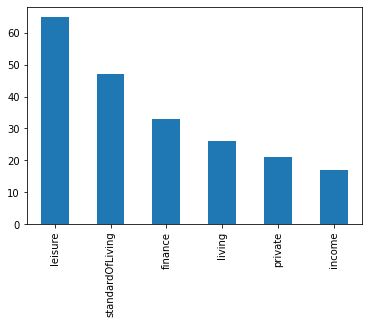

In [138]:
# look at distribution of classes
print(transactions_raw["label"].value_counts())
transactions_raw["label"].value_counts().plot(kind="bar")
# class imbalance

In [139]:
# attribute values overview
for columnName, columnData in transactions_raw.iteritems():
    print("attribute:",columnName)
    print("number of unique values:", len(list(columnData.unique())))
    print(list(columnData.unique())[0:15])
    print()


attribute: Unnamed: 0
number of unique values: 209
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

attribute: Auftragskonto
number of unique values: 3
[89990201.0, 89990210.0, nan]

attribute: Buchungstag
number of unique values: 85
['28.07.2016', '27.07.2016', '21.07.2016', '20.07.2016', '18.07.2016', '15.07.2016', '08.07.2016', '05.07.2016', '04.07.2016', '01.07.2016', '29.06.2016', '28.06.2016', '15.06.2016', '10.06.2016', '08.06.2016']

attribute: Valutadatum
number of unique values: 85
['28.07.2016', '27.07.2016', '21.07.2016', '20.07.2016', '18.07.2016', '15.07.2016', '08.07.2016', '05.07.2016', '04.07.2016', '01.07.2016', '29.06.2016', '28.06.2016', '15.06.2016', '10.06.2016', '08.06.2016']

attribute: Buchungstext
number of unique values: 14
['Lohn / Gehalt', 'Miete', 'Bargeld', 'Lebensmittel / Getraenke', 'Spontanausgabe', 'Mieteinnahmen', 'Drogerie', 'Geldanlage', 'Gehalt/Rente', 'Lastschrift (Einzugsermächtigung)', 'Dauerauftrag', 'Abschluss', 'Euro-Überweisung', 'Eurosc

In [140]:
# remove waehrung as there is only one value
# remove original id
transactions = transactions_raw
transactions = transactions.drop(["Waehrung"], axis=1)
transactions = transactions.drop(["Unnamed: 0"], axis=1)

In [141]:
# set nan to "missing" for Auftragskonto to be usable for classifier
transactions['Auftragskonto'].fillna('missing', inplace=True)

# delete two rows with missing values, maybe leave later in case Kontonummer or BLZ will be removed completely
transactions = transactions.dropna()
transactions.reset_index(drop=True)
transactions.isnull().sum()
# all missing values dealt with

Auftragskonto                        0
Buchungstag                          0
Valutadatum                          0
Buchungstext                         0
Verwendungszweck                     0
Beguenstigter/Zahlungspflichtiger    0
Kontonummer                          0
BLZ                                  0
Betrag                               0
label                                0
dtype: int64

In [114]:
# check if Valuta and Buchungsdatum are always equal
buchungstag = transactions[['Buchungstag']]
buchungstag.reset_index(drop=True, inplace=True)
valutadatum = transactions[['Valutadatum']]
valutadatum.reset_index(drop=True, inplace=True)

for i in range (buchungstag.size):
    if buchungstag.loc[i, "Buchungstag"] != valutadatum.loc[i, "Valutadatum"]:
        print("difference:", i,buchungstag.loc[i, "Buchungstag"], valutadatum.loc[i, "Valutadatum"])

# since they only differ in one of over 200 cases, one of them can be disregarded quite safely
transactions = transactions.drop(["Valutadatum"], axis=1)



difference: 124 11.02.2016 12.02.2016


In [118]:
# running this may take ~30s as 255 models are evaluated
model = GaussianNB()


classes = transactions[["label"]].values.ravel()
features_all = ['Auftragskonto', 'Buchungstag','Buchungstext', 'Verwendungszweck', 'Beguenstigter/Zahlungspflichtiger','Kontonummer', 'BLZ', 'Betrag']
features_selection = []
metric = "accuracy"

for i in range(1, len(features_all)+1):
    combinations = list(itertools.combinations(features_all, i))
    max_score = 0
    for j in range(len(combinations)):
        features_selection = list(combinations[j])
        counts = pd.get_dummies(transactions[features_selection])
        scores = cross_val_score(model, counts, classes, cv=15, scoring = metric)
        mean_score = scores.mean()
        if mean_score > max_score:
             max_score = mean_score
             best_feature_selection = features_selection
    print("Maximum", metric,"using",i, "attribute(s) is: {0:.3f}".format(max_score))
    print("Selected features:", best_feature_selection)
    print()

print("all feature combinations evaluated")
    


Maximum accuracy using 1 attribute(s) is: 0.867
Selected features: ['Kontonummer']

Maximum accuracy using 2 attribute(s) is: 0.929
Selected features: ['Beguenstigter/Zahlungspflichtiger', 'BLZ']

Maximum accuracy using 3 attribute(s) is: 0.948
Selected features: ['Beguenstigter/Zahlungspflichtiger', 'BLZ', 'Betrag']

Maximum accuracy using 4 attribute(s) is: 0.952
Selected features: ['Buchungstext', 'Beguenstigter/Zahlungspflichtiger', 'BLZ', 'Betrag']

Maximum accuracy using 5 attribute(s) is: 0.952
Selected features: ['Auftragskonto', 'Buchungstext', 'Beguenstigter/Zahlungspflichtiger', 'BLZ', 'Betrag']

Maximum accuracy using 6 attribute(s) is: 0.952
Selected features: ['Auftragskonto', 'Buchungstext', 'Verwendungszweck', 'Beguenstigter/Zahlungspflichtiger', 'BLZ', 'Betrag']

Maximum accuracy using 7 attribute(s) is: 0.952
Selected features: ['Auftragskonto', 'Buchungstext', 'Verwendungszweck', 'Beguenstigter/Zahlungspflichtiger', 'Kontonummer', 'BLZ', 'Betrag']

Maximum accuracy u

In [154]:
#houldout split for f1 calculation, 25% test, 75% training
transaction_attributes = transactions[['Auftragskonto', 'Buchungstag','Buchungstext', 'Verwendungszweck', 'Beguenstigter/Zahlungspflichtiger','Kontonummer', 'BLZ', 'Betrag']]
transaction_labels = transactions[['label']]

x_train, x_test, y_train, y_test = train_test_split(transaction_attributes,transaction_labels, test_size=0.25, random_state = 1337)

In [126]:
# running this may take ~30s as 255 models are evaluated
model = GaussianNB()


classes = transactions[["label"]].values.ravel()
features_all = ['Auftragskonto', 'Buchungstag','Buchungstext', 'Verwendungszweck', 'Beguenstigter/Zahlungspflichtiger','Kontonummer', 'BLZ', 'Betrag']
features_selection = []
metric = "accuracy"
print(transactions.shape[0])
#transactions_train = transactions[0:end]


for i in range(1, len(features_all)+1):
    combinations = list(itertools.combinations(features_all, i))
    max_score = 0
    for j in range(len(combinations)):
        features_selection = list(combinations[j])

        x_train = pd.get_dummies(transactions_train[features_selection])
        y_train = pd.DataFrame(transactions_train['label'])


        
        
        
        
        model.fit()

        scores = cross_validate(model, counts, classes, cv=15, scoring = metric)

        mean_score = scores.mean()
        if mean_score > max_score:
             max_score = mean_score
             best_feature_selection = features_selection
    print("Maximum", metric,"using",i, "attribute(s) is: {0:.3f}".format(max_score))
    print("Selected features:", best_feature_selection)
    print()

print("all feature combinations evaluated")
    

208


TypeError: fit() missing 2 required positional arguments: 'X' and 'y'